# 北京市PM2.5浓度预测

## 导入相关的库

In [1]:
'''使用BP神经网络对北京市PM2.5浓度进行预测'''
# 首先先导入相关的库
# 数据处理板块
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
# sklearn板块
import sklearn 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split # 这个函数的主要作用是进行训练集和测试集的拆分
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.neural_network import MLPRegressor # BP神经网络
from sklearn.ensemble import AdaBoostRegressor  # AdaBoost
from sklearn.ensemble import GradientBoostingRegressor # GBDT算法
from sklearn.ensemble import RandomForestRegressor # RandomForest算法
from sklearn.tree import DecisionTreeRegressor # CART回归树
from xgboost import XGBRegressor # XGBoost算法
from sklearn.model_selection import KFold #  K折交叉验证
import sys
from io import StringIO
import warnings
warnings.filterwarnings("ignore")
#绘图板块
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = 12, 5
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 替换sans-serif字体
plt.rcParams['axes.unicode_minus'] = False   # 坐标轴负数的负号显示
import pyecharts
from pyecharts.charts import *
from pyecharts.components import Table
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from pyecharts.globals import ThemeType


## 定义类

In [39]:
# 定义类
class BP_network():
    def __init__(self):
        print("my BP network start!!!")
    # 数据预处理部分
    def preprocessing_data_for_Beijing(self):
        '''
        类方法介绍：该类方法会返回一个北京市的数据框，对应的x，对应的y
        这里我们使用北京市多个地方的均值来模拟北京市的情况
        此处需要注意一点此时数据是已经经过标准化后的，并且我们将离散型的数据转换为连续型的数据
        '''
        # 先创建一个城市列表
        city_lst = ['Aotizhongxin','Changping','Dingling','Dongsi','Guanyuan','Gucheng','Huairou',\
                    'Nongzhanguan','Shunyi','Tiantan','Wanliu','Wanshouxigong']
        # 创建一个空字典，用于存放每一个地区对应的数据集
        data_param = dict()
        all_lst=[]
        for town in city_lst:
            df = pd.read_csv(f'C:/Users/lucien7676/Desktop/机器学习大作业/PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_{town}_20130301-20170228.csv')
            # 将第一列No和最后一列城市去掉
            df = df.where(df.notnull(),None)# 这里的nan很奇怪 所以我先将其处理为None类型
            df = df.iloc[:,1:-1]
            # 这里是处理完之后的数据框 下面将连续型的数据进行处理
            if city_lst.index(town) == 0:
                winddirection = list(set(df['wd'].tolist())) # 为了同一标准，我们以第一个文件中风向的embedding作为基准
                # 首先我们需要将None值给剔除掉
                winddirection.remove(None)
                # 下面我们就得到一个编码的序列
                embedding = [i for i in range(len(winddirection))] # 这个列表是一个装的是对应属性的embedding
            # 首先先复制一个新的数据框的格式
            target_new = df.copy()
            # 将属性值的数据进行修改
            all_list = target_new['wd'].tolist()
            new_wd=[]
            #print(embedding)
            for i in range(len(all_list)):
                wind = all_list[i]
                if wind == None:
                    new_wd.append(None)
                else:
                    index=winddirection.index(wind)
                    new_wd.append(embedding[index])
            # 这里我们将新的数据框进行转换
            target_new['wd'] = new_wd
            # 此时target_new就已经拼接好了，然后我们将target_new中None的位置转变为np.nan
            target_new[target_new==None]=np.nan
            # 首先先将其转化为array类型 此时为二维数组
            need_array=target_new.to_numpy()
            need_array=need_array.astype(float)
            all_lst.append(need_array) 
        x=np.array(all_lst)
        # 用北京不同的地区的均值来代表北京
        Beijing_data=np.nanmean(x,axis=0)
        # 这里我们可以先将其合成为一个数据框的形式
        df_Beijing=pd.DataFrame(Beijing_data)
        df_Beijing.columns=df.columns
        # 这里由于PM2.5位于数据框中间的位置，因此我们先将其处理一下
        df1=df_Beijing.drop(['PM2.5'],axis=1)
        df1['PM2.5']=df_Beijing['PM2.5']
        # 现在再剔除掉nan值
        df1 = df1.dropna()
        #提取出wd所在的列
        wd_index = list(df1.columns).index('wd') # 方便后面进行PCA降维
        # 接下来对其进行Z-score标准化
        all_data_array=df1.to_numpy()
        #print(all_data_array.shape)
        mean_=np.nanmean(all_data_array,axis=0,keepdims=True)
        #print(mean_.shape)
        std_= np.nanstd(all_data_array,axis=0,keepdims=True)
        #print(std_.shape)
        modify_data=(all_data_array-mean_)/std_
        # 下面提取出X，y出来
        modify_x = modify_data[:,:-1]
        modify_y = modify_data[:,-1]
        data_param['dataframe']=df1
        data_param['all_x']=modify_x
        data_param['all_y']=modify_y
        # 下面还要进行返回均值和标准差方便后面进行逆标准化换算
        data_param['mean']=mean_
        data_param['std']=std_
        data_param['wd_index']=wd_index
        return data_param
    def split_train_test(self,data_param,method=1,PCA_low=False):
        '''
        这个类方法的主要作用是将数据集进行切分
        这个类方法只是切分了训练集和测试集，但是我们还需要对
        这里设置了一个参数method 通过改变这个参数我们可以进行修改不同分数据的方法
        method = 1 就是手动数据 直接将最后100个样本当作测试数据
        method = 2 使用sklearn中的split_train_test的方法 设置testing的占比为0.1
        '''
        # 提取X和y的数组的形式
        all_x = data_param["all_x"]
        all_y = data_param["all_y"]
        all_y = np.array([all_y]).T
        # 首先我们先提取出前面的风向对应的index出来
        wind_index = data_param['wd_index']
        # 接下来将风向数据提取出来，然后将剩下的特征做PCA降维，然后将风向的数据再重新加进去，试一下效果
        if PCA_low == True:
            # 如果PCA_low设置为True，则我们就进行PCA降维，
            # 首先我们需要明白对于名义变量来说，此处名义变量为风向
            # 我们是不能对名义变量进行PCA降维的 因此我们需要将其提取出来，然后对剩下14个变量进行PCA降维的操作
            # 首先我们先存储wd这一列的信息
            wind = np.array([all_x[:,wind_index]]).T
            # 删除掉风向的这一列
            all_x = np.delete(all_x,wind_index,1)
            # 这里首先先创建一个pca实例对象
            pca = PCA(n_components=8)
            reduced_x = pca.fit_transform(all_x)
            # 降维之后，我们再将其风向wd进行拼接
            all_x = np.hstack([reduced_x,wind]) # 得到新的all_x
        # 这里我们使用sklearn中的split的方法进行分隔数据的形式   
        # 这里我们需要分情况进行讨论
        if method == 1:
            # 取最后100个样本数据作为testing data
            x_train = all_x[:-100,:]
            y_train = all_y[:-100,:]
            x_test = all_x[-100:,:]
            y_test = all_y[-100:,:]
            # 将处理完后的数据装到字典中去
            tp_data_dict={'x_train':x_train,'y_train':y_train,"x_test":x_test,"y_test":y_test,"all_x":all_x,"all_y":all_y}
        elif method == 2:
            # 这里为了防止出现随机性，我们设置了随机种子
            x_train,x_test,y_train,y_test = train_test_split(all_x,all_y,test_size=0.1,random_state=42)
            # 下面将分割完后的数据装到字典中去
            tp_data_dict={'x_train':x_train,'y_train':y_train,"x_test":x_test,"y_test":y_test,"all_x":all_x,"all_y":all_y}
        return tp_data_dict  
    # 神经网络部分
    # 下面直接调用sklearn中的BP神经网络
    # 这里下面这个类方法主要是对各个北京市的PM2.5的浓度进行预测
    def network(self,data_param,split_data=None,want='BP',layers=2,n1=50,n2=20,n3=10,n4=5,print_ok=True,X_train=None,\
                X_test=None,Y_train=None,Y_test=None):
        '''
        这里我们可以传入参数want实现创建不同的回归模型
            want的参数有 BP CART XGBoost AdaBoost GDBT RF
        并且在这里我们会尝试使用不同层数的BP神经网络进行预测
        在这里更新梯度的方式我们会选用Adam算法进行更新参数
        '''
        # 在此处进行修改参数
        # 我们首先使用的是两层的神经网络，在这里我们使用的激活函数是relu激活函数
        # 首先此处可以调节的可以是激活函数的类型 和 隐藏层的数目 和 神经元的个数
        if layers==2:
            nueral=(n1,n2)# 这里我们先传入一个神经元的个数的元组
        elif layers==3:
            nueral=(n1,n2,n3)
        else:
            nueral=(n1,n2,n3,n4)
        if want=='BP':
            nn = MLPRegressor(hidden_layer_sizes=nueral,random_state=10,learning_rate_init=0.001,activation='relu',solver='adam',max_iter=1000,verbose=1)
        elif want=='CART':
            nn =  DecisionTreeRegressor(max_depth=10)
        elif want=="XGBoost":
            nn = XGBRegressor(verbose=1)
        elif want=="AdaBoost":
            nn = AdaBoostRegressor()
        elif want == "GBDT":
            nn = GradientBoostingRegressor(verbose=1)
        elif want == "RF":
            nn = RandomForestRegressor(verbose=1)
        # 这里我们是提取出对应的数据
        if split_data==None:
            x_train = X_train
            x_test = X_test
            y_train = Y_train
            y_test = Y_test
        elif X_train == None or X_test == None or Y_train == None or Y_test == None:
            x_train = split_data["x_train"]
            x_test = split_data["x_test"]
            y_train = split_data['y_train']
            y_test = split_data["y_test"]
        else:
            return None
        all_x = data_param["all_x"]
        all_y = data_param["all_y"]
        # 下面先进行记录每一次epoch对应的loss
        if want == "BP":
            old_stdout = sys.stdout
            sys.stdout = mystdout = StringIO()
        # 接下来开始进行训练模型 
        nn.fit(x_train,y_train)
        # 下面开始处理得到输出的东西 并且存储到列表中
        loss_list = []
        if want == 'BP':
            sys.stdout = old_stdout
            loss_history = mystdout.getvalue()
            
            # 下面是将所有的输出的内容进行存储
            for line in loss_history.split('\n'):
                if(len(line.split("loss =")) == 1):
                    continue
                loss_list.append(float(line.split("loss =")[-1]))
        if print_ok==True and want =='BP':
            plt.figure()
            plt.plot(np.arange(len(loss_list)),loss_list,color='red')
            plt.xlabel("Time in epochs")
            plt.ylabel("Loss")
            plt.show()
        # 接下来使用训练出来的模型进行预测
        y_predict = nn.predict(x_test) # 对测试数据集进行验证
        # 可以使用模型对整体进行一次预测
        y_all_predict = nn.predict(all_x) # 这里我们对全部进行预测
        # 这里我们可以进行评估使用R2系数和MSE进行评估
        # 首先我们要先将y_test处理成列表的形式
        y_test_1 = y_test.tolist() # 将其转换为列表的形式
        y_test_all = all_y.tolist() # 将整体的y进行转换
        # 首先我们会先对测试数据进行评估
        R2_1 = r2_score(y_test_1,y_predict)
        MSE_1 = mean_squared_error(y_test_1,y_predict)
        # 第二个方面我们会对整体数据的预测进行评估
        R2_2 = r2_score(y_test_all,y_all_predict)
        MSE_2 = mean_squared_error(y_test_all,y_all_predict)
        nn_dict = {
                            "模型":nn,
                            "all_predict":y_all_predict.tolist(),
                            "all_y":y_test_all,
                            "predict":y_predict.tolist(),
                            "y_test":y_test_1,
                            "R2_1":R2_1,
                            "MSE_1":MSE_1,
                            "R2_2":R2_2,
                            "MSE_2":MSE_2,
                            "loss_process":loss_list
                           }
            #break # 这里先做一个测试
        return nn_dict # 这里我们就会以一个字典的形式进行返回
    # 模型评估部分
    def N_fold(self,data_param,want="BP",print_ok=False,layers=2,n1=50,n2=30,n3=10,n4=5):
        '''
        此处十折交叉验证是用来验证模型的好坏程度
        '''
        # 首先我们先进行读取数据
        X = data_param["all_x"]
        Y = data_param["all_y"]
        Y = np.array([Y]).T   # 这里我们注意到Y是一个一维的数组的形式 因此我们进行了转换为二维数组并且为列向量的形式
        all_da = np.hstack([X,Y]) # 这里是将其进行拼接的过程
        # 接下来我们先创建一个K折交叉验证的实例对象
        kf = KFold(n_splits=10)  # 这里设置的是10折交叉验证
        # 下面定义一个空列表进行承装测试集所对应的
        ten_fold = []
        for train_index, test_index in kf.split(all_da):
            # 下面是得到每一折所对应的训练集和验证集 
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            # 这里我们不需要进行画出图
            nn_tp = self.network(data_param=data_param,layers=layers,want=want,n1=n1,n2=n2,n3=n3,n4=n4,\
                                 print_ok = print_ok,X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test)
            ten_fold.append(nn_tp["MSE_1"])# 这里每一折在测试集中测试后所得到的MSE
        # 下面开始计算十折所对应的MSE的平均值，并进行返回
        avg = np.mean(np.array(ten_fold))
        # 下面直接将字典 进行返回
        return {"avg":avg,"ten_fold":ten_fold}
    # 可视化部分
    # 可视化部分的话主要分为两个部分 第一个部分为预测值和真实值之间的对比，第二个部分为模型训练过程中loss的变化
    # 主要部分为尝试多个层多个神经元的神经网络，进行横向对比。
    def contrast(self,data_param,mode=1,layers=2,best_dict=None):
        '''
        这里传入一个mode参数
            如果mode=1 表示的对BP神经网络进行预测
            如果mode=2 表示的是不同模型之间的比较
        这个函数输出的是BP神经网络不同层和不同神经元之间的效果
        后面会进行绘制十折交叉验证的折线图的比较
        '''
        if mode == 1:
            # 这里是想要对比不同的层数，不同
            if layers == 2:
                # 设置一个
                low = None
                n1_low = None
                n2_low = None
                low_lst = None 
                for n1 in range(48,51):
                    for n2 in range(14,16):
                        tp_dict = self.N_fold(data_param,layers=layers,n1=n1,n2=n2)
                        avg_ = tp_dict['avg']
                        pro_ = tp_dict['ten_fold'] 
                        if n1_low == None or n2_low == None or low == None or low_lst == None or avg_ < low:
                            low = avg_
                            n1_low = n1
                            n2_low = n2
                            low_lst = pro_
                        else:
                            continue
                best_tp_dict = self.N_fold(data_param,print_ok=True,layers=layers,n1=n1_low,n2=n2_low)
                return {"n1":n1_low,"n2":n2_low,"dict":best_tp_dict}
            elif layers == 3:
                # 设置一个
                low = None
                n1_low = None
                n2_low = None
                n3_low = None
                low_lst = None 
                for n1 in range(47,51):
                    for n2 in range(22,25):
                        for n3 in range(5,8):
                            tp_dict = self.N_fold(data_param,layers=layers,n1=n1,n2=n2,n3=n3)
                            avg_ = tp_dict['avg']
                            pro_ = tp_dict['ten_fold'] 
                            if n1_low == None or n2_low == None or n3_low == None or low == None or low_lst == None or avg_ < low:
                                low = avg_
                                n1_low = n1
                                n2_low = n2
                                n3_low = n3
                                low_lst = pro_
                            else:
                                continue
                best_tp_dict = self.N_fold(data_param,print_ok=True,layers=layers,n1=n1_low,n2=n2_low,n3=n3_low)
                return {"n1":n1_low,"n2":n2_low,"n3":n3_low,"dict":best_tp_dict}
            # 上面的两个会输出一个最佳的n和对应的loss的过程
            else:
                return None
        elif mode==2:
            # BP CART XGBoost AdaBoost GBDT RF
            model_name=["BP","CART","XGBoost","AdaBoost","GBDT","RF"]
            model_mse=[]
            # 这里主要做的就是使用这几种网络进行横向对比
            names = list(best_dict.keys())
            if len(names) == 3:
                layers=2
                n1 = best_dict["n1"]
                n2 = best_dict["n2"]
                n3 = 10
            else:
                layers=3
                n1 = best_dict["n1"]
                n2 = best_dict["n2"]
                n3 = best_dict["n3"]
            for item in model_name:
                if item == "BP":
                    tp1_dict = self.N_fold(data_param,want=item,print_ok=False,layers=layers,n1=n1,n2=n2,n3=n3,n4=5)
                    avg1_ = tp1_dict['avg']
                    model_mse.append(avg1_)
                else:
                    tp1_dict = self.N_fold(data_param,want=item,print_ok=False)
                    avg1_ = tp1_dict['avg']
                    model_mse.append(avg1_)
            best_name=model_name[model_mse.index(min(model_mse))]
            print(f"拟合程度最好的是{best_name},对应的MSE为{min(model_mse)}")
            return {"model_name":model_name,"model_mse":model_mse,"best_name":best_name,"best_MSE":min(model_mse)}
            
    # 我们可以在同一张图内显示不同模型预测的结果和真实结果之间的差别
    # 编写主程序
    def main(self):
        '''
        这个类方法主要是为了得到最优的参数模型
        第一个方面 我们会得到两层BP神经网络的最优
        第二个方面 我们会得到三层BP神经网络的最优
        第三个方面 我们会得到多个不同模型中的最优
        '''
        data_param = self.preprocessing_data_for_Beijing()
        split_data = self.split_train_test(data_param,method=2)
        # 首先对BP神经网络比较
        # 这里我们先得到一个二层中最好的参数
        best1_dict = self.contrast(data_param,mode=1,layers=2)
        # 这里我们得到三层中最好的参数
        best2_dict = self.contrast(data_param,mode=1,layers=3)
        # 然后我们先进行对比2层网络和三层网络的mse谁的比较低一点
        best3_dict = self.contrast(data_param,mode=2,best_dict=best1_dict)
        best4_dict = self.contrast(data_param,mode=2,best_dict=best2_dict)
        return best1_dict,best2_dict,best3_dict,best4_dict
    def my_plot(self,x,nn_dict,data_param,what):
        # 下面先获得所有的预测和均值标准差
        y_all_predict = np.array(nn_dict["all_predict"])
        all_y = np.array(data_param['all_y'])
        mean_ = data_param['mean']
        std_ = data_param['std']
        mean_y = mean_[0][-1]
        std_y = std_[0][-1]
        # 下面分别对其进行还原
        real_ = (all_y*std_y+mean_y).tolist()
        pred_ = (y_all_predict*std_y+mean_y).tolist()
        # 需要进行修改
        plt.figure(figsize=(20,8),dpi=100)
        plt.plot(x,pred_,label=what,color='black',linestyle=':')  #还有linewidth 和 alpha透明度
        plt.plot(x,real_,label="真实值",color='red',linestyle='--') #颜色还有其他的颜色代码
        #plt.plot(x,t_3,label="通项公式算法",color='yellow',linestyle='-')
        plt.xlabel("时间")
        plt.ylabel("PM2.5浓度")
        plt.title(f"{what}预测PM2.5浓度")
        plt.grid(alpha=0.1,color='r',linestyle='--')#设置网格 alpha设置不透明度
        #添加图例
        plt.legend(loc='upper right')
        plt.show()
        # 下面使用pyecharts进行可视化
        c=(
                Line(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
            .add_xaxis(x)
            .add_yaxis(what,pred_)
            .add_xaxis(x)
            .add_yaxis('真实值',real_)
            .set_global_opts(
                title_opts=opts.TitleOpts(title=f"北京市PM2.5浓度预测"),
                datazoom_opts=opts.DataZoomOpts(),
            ).set_series_opts(label_opts=opts.LabelOpts(is_show=False))

        )
        return c
    def main2(self,want='BP',layers=2,n1=50,n2=20,n3=10,n4=5,PCA_low=False):
        '''
        这个类方法能实现不同的方法进行绘制图像
        这个 主函数主要是为了画出图像
        '''
        # 首先我们先获得对应的数据
        data_param = self.preprocessing_data_for_Beijing()
        x = data_param['dataframe'].index.tolist()
        if PCA_low == False:
            split_data = self.split_train_test(data_param,method=1) # 这里由于点的个数太多 其实我们可以只取测试集的数据进行绘制图像
        else:
            split_data = self.split_train_test(data_param,method=1,PCA_low=True)
            # print(split_data)
            want = "BP"
        nn_dict = self.network(data_param,split_data=split_data,want=want,layers=layers,n1=n1,n2=n2,n3=n3,n4=n4)
        mse_2=nn_dict["MSE_2"]
        R2=nn_dict["R2_2"]
        print(f"{want}模型的MSE为{mse_2}")
        print(f"{want}模型的R2为{R2}")
        #print(nn_dict["all_predict"])
        c = self.my_plot(x,nn_dict,data_param,want)
        return nn_dict,c
    

my BP network start!!!


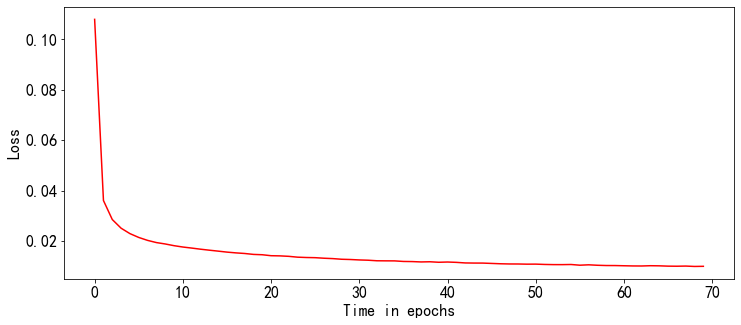

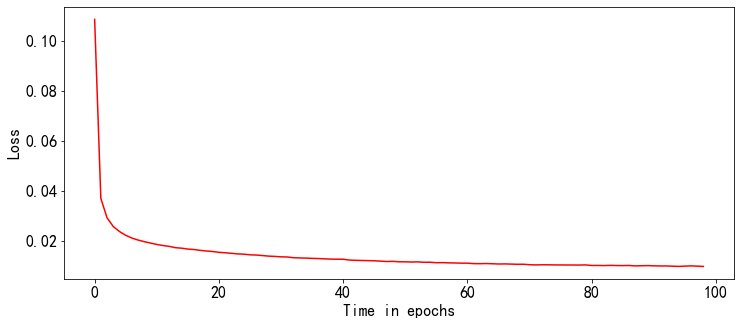

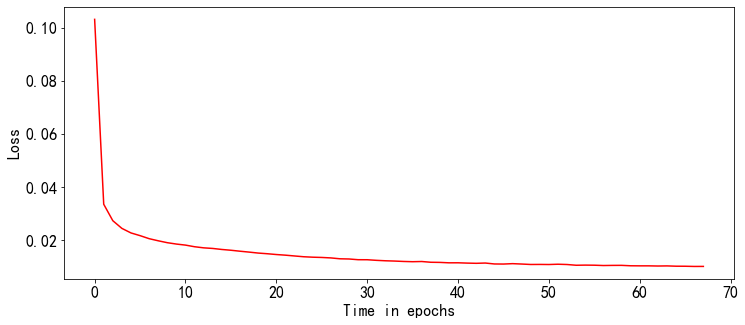

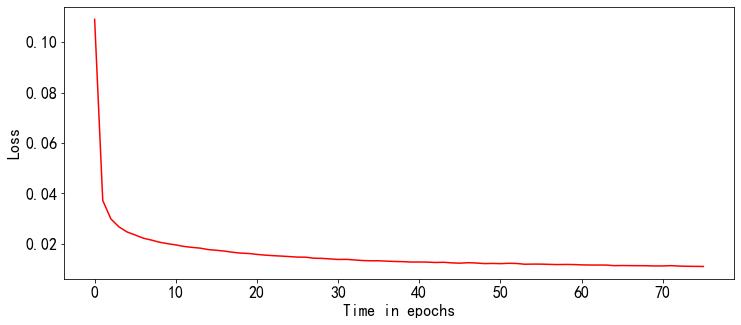

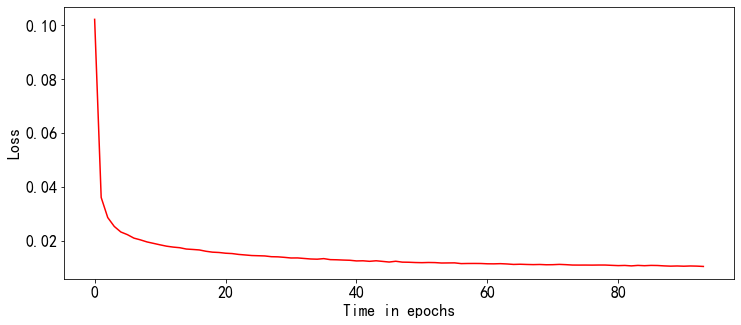

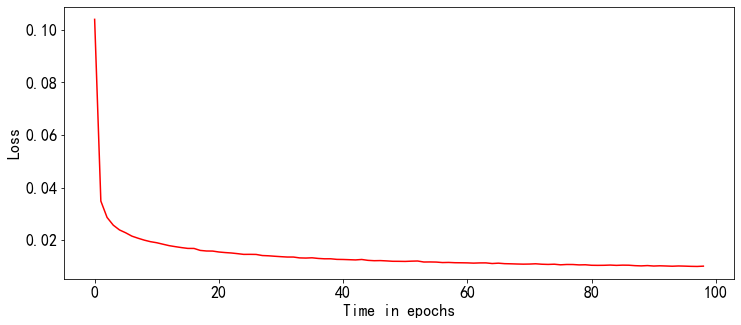

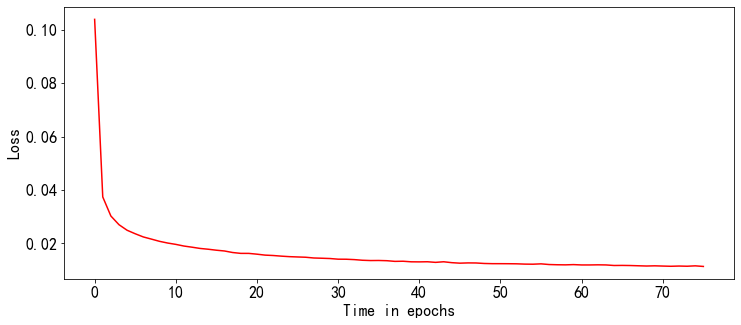

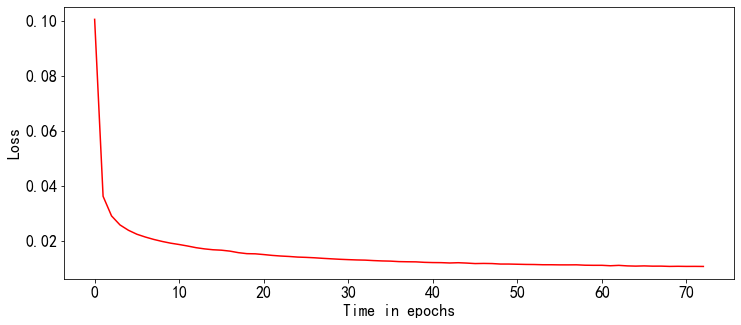

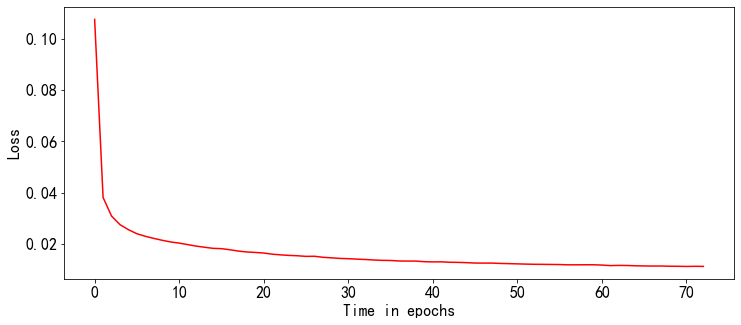

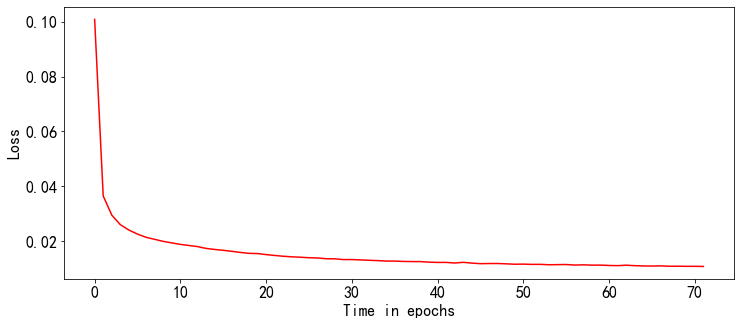

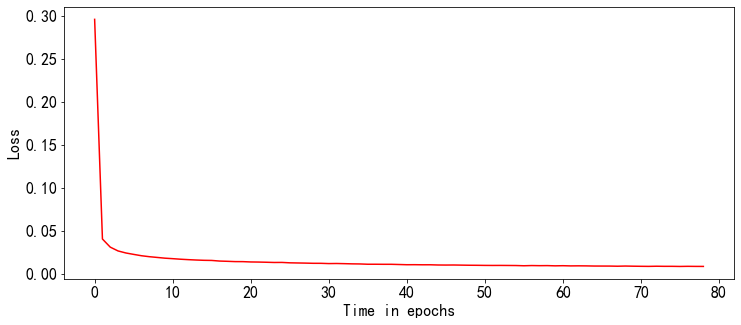

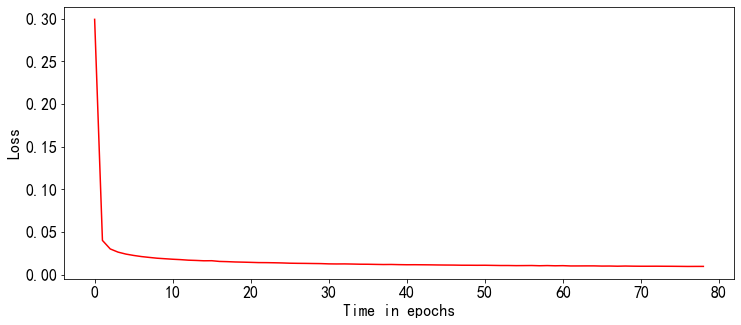

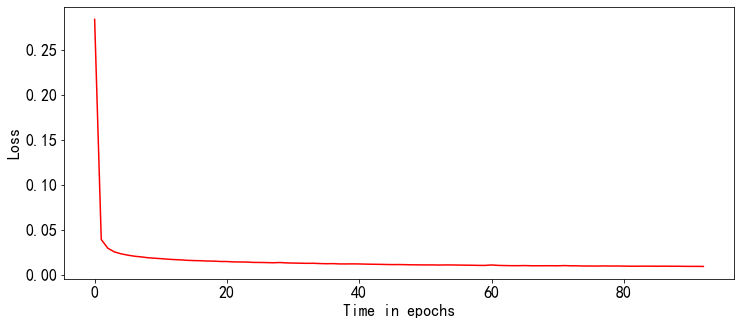

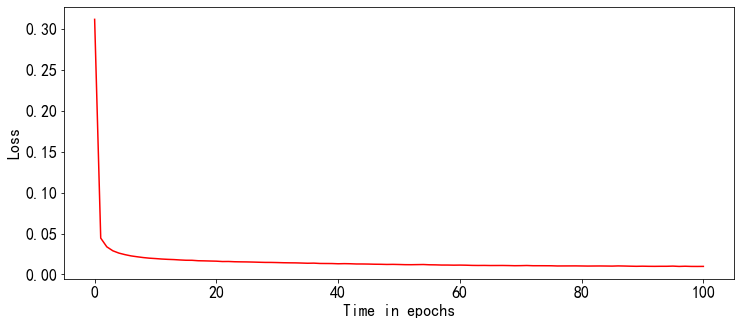

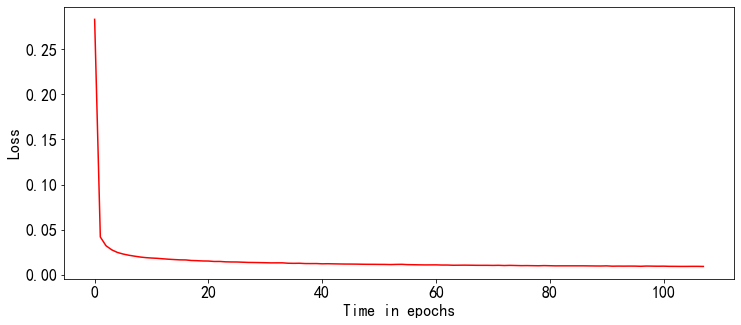

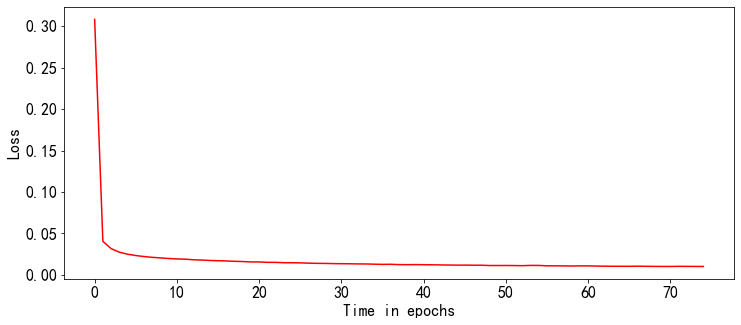

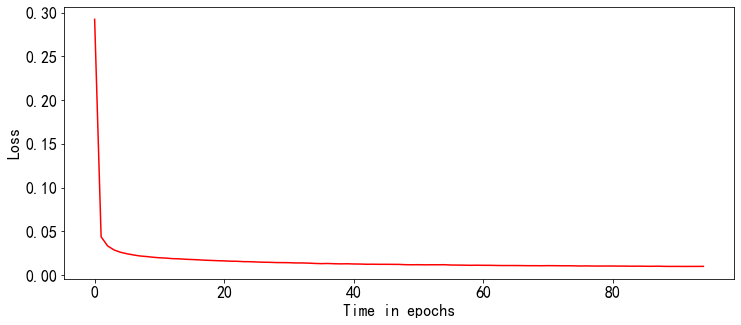

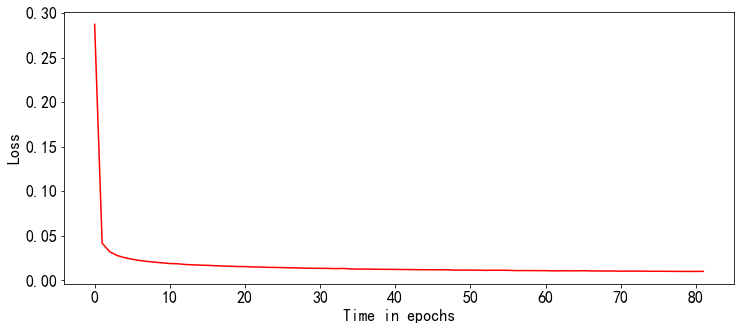

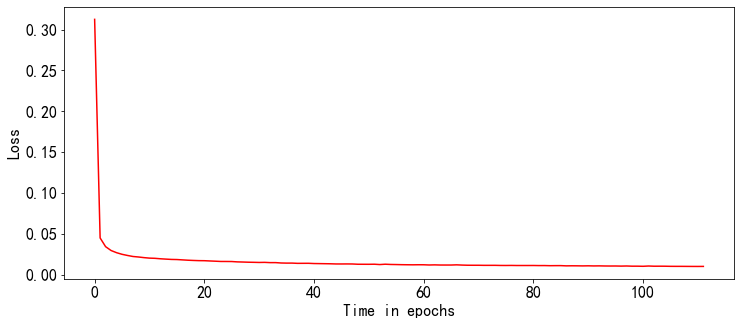

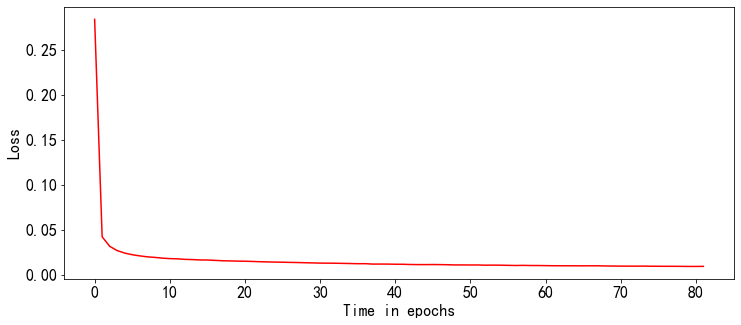

[10:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:58:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:58:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a fa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

拟合程度最好的是XGBoost,对应的MSE为0.0569483605391166
[11:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

拟合程度最好的是XGBoost,对应的MSE为0.0569483605391166


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [13]:
# 主程序编写
if __name__ == "__main__":
    # 首先先创建类的实例对象
    lrc = BP_network()
    # 下面开始使用类方法
    #nn_dict,c=lrc.main2(want='GBDT')
    di1,di2,di3 = lrc.main()
#     nn_dict = lrc.network(split_data,want="BP") # RF CART BP XGBoost AdaBoost GBDT
#     all_=lrc.predict_Beijing(data_param,nn_dict)

### 由于上面的循环使用十折交叉验证法进行验证的，因此跑的时间比较久，如果想要看下面的pyecharts的图片的话，我们就需要直接上述得到结果
### 这里提前声明一下由于在查看pyecharts图可能不同电脑会出现跑不出来的情况，因此这里我们下载为html的形式以便后面如果跑不出来可以进行查看

In [18]:
data_param = lrc.preprocessing_data_for_Beijing()
best4_dict = lrc.contrast(data_param,mode=2,best_dict=di2)

[16:13:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:13:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:13:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a fa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

拟合程度最好的是XGBoost,对应的MSE为0.0569483605391166


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [15]:
print(di1)
print(di2)
print(di3)
# 由于上面的程序跑的时间有点久，因此我们将重新创建 一个类对象

{'n1': 50, 'n2': 14, 'dict': {'avg': 0.06093709778079488, 'ten_fold': [0.0792533904352858, 0.06490637296771193, 0.07521600481676448, 0.03609144640760192, 0.06389795539702474, 0.05349075219696343, 0.033763536855358434, 0.055145350949226006, 0.022869529459814207, 0.12473663832219795]}}
{'n1': 50, 'n2': 24, 'n3': 7, 'dict': {'avg': 0.06336348639053363, 'ten_fold': [0.07632638035573756, 0.09699912612108925, 0.08468145633635103, 0.040555398407643696, 0.07087420509744138, 0.058992515858676695, 0.044896112249406324, 0.04664884545419614, 0.02052495738859579, 0.09313586663619836]}}
{'model_name': ['BP', 'CART', 'XGBoost', 'AdaBoost', 'GDBT', 'RF'], 'model_mse': [0.06093709778079488, 0.09349440852286299, 0.0569483605391166, 0.14811470481841504, 0.06306833731988207, 0.05983506356933681], 'best_name': 'XGBoost', 'best_MSE': 0.0569483605391166}


In [19]:
print(best4_dict)

{'model_name': ['BP', 'CART', 'XGBoost', 'AdaBoost', 'GDBT', 'RF'], 'model_mse': [0.06336348639053363, 0.09387600443059094, 0.0569483605391166, 0.1457461113928206, 0.0630183669883201, 0.0592289681202971], 'best_name': 'XGBoost', 'best_MSE': 0.0569483605391166}


In [3]:
# 这里手动将上述的字典进行存储，方便后面能够直接进行调用
di1={'n1': 50, 'n2': 14, 'dict': {'avg': 0.06093709778079488, 'ten_fold': [0.0792533904352858, 0.06490637296771193, 0.07521600481676448, 0.03609144640760192, 0.06389795539702474, 0.05349075219696343, 0.033763536855358434, 0.055145350949226006, 0.022869529459814207, 0.12473663832219795]}}
di2={'n1': 50, 'n2': 24, 'n3': 7, 'dict': {'avg': 0.06336348639053363, 'ten_fold': [0.07632638035573756, 0.09699912612108925, 0.08468145633635103, 0.040555398407643696, 0.07087420509744138, 0.058992515858676695, 0.044896112249406324, 0.04664884545419614, 0.02052495738859579, 0.09313586663619836]}}
di3={'model_name': ['BP', 'CART', 'XGBoost', 'AdaBoost', 'GDBT', 'RF'], 'model_mse': [0.06093709778079488, 0.09349440852286299, 0.0569483605391166, 0.14811470481841504, 0.06306833731988207, 0.05983506356933681], 'best_name': 'XGBoost', 'best_MSE': 0.0569483605391166}

In [4]:
di4={'model_name': ['BP', 'CART', 'XGBoost', 'AdaBoost', 'GDBT', 'RF'], 'model_mse': [0.06336348639053363, 0.09387600443059094, 0.0569483605391166, 0.1457461113928206, 0.0630183669883201, 0.0592289681202971], 'best_name': 'XGBoost', 'best_MSE': 0.0569483605391166}

In [5]:
## 下面将会进行对比

my BP network start!!!


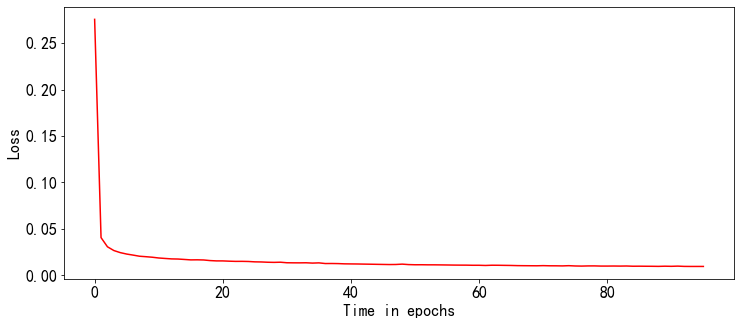

BP模型的MSE为0.019259190245842436
BP模型的R2为0.9807408097541576


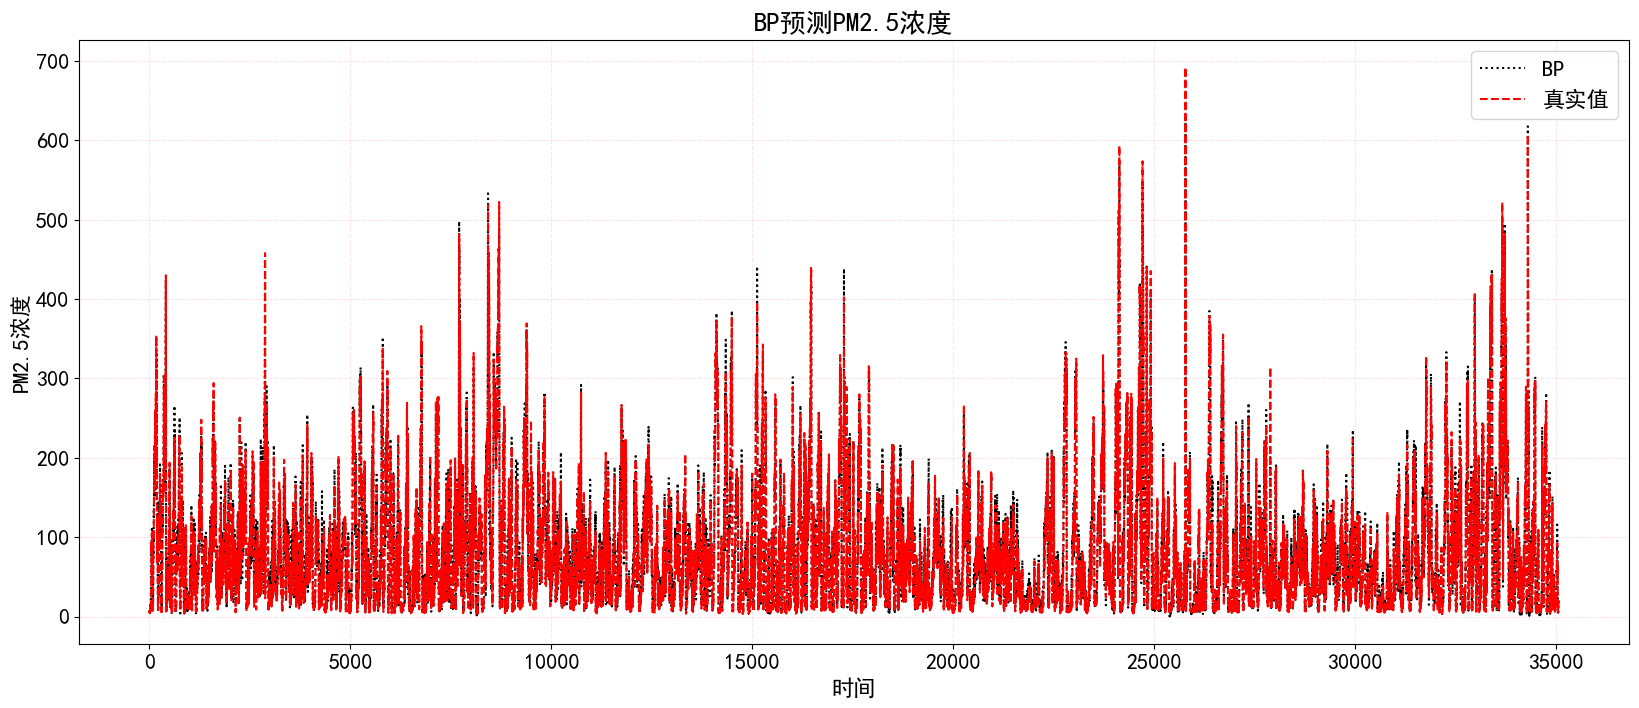

In [14]:
#下面进行绘制多种图像进行横向对比
# 拿到最佳的BP神经网络的参数
lrc = BP_network()
dic1,c1 = lrc.main2(want="BP",layers=3,n1=di2['n1'],n2=di2['n2'],n3=di2['n3'])
# dic1_,c1_ = lrc.main2(want="BP",layers=2,n1=di1["n1"],n2=di2["n2"])# 这里我们得到对应的字典
# dic2,c2 = lrc.main2(want="GDBT")
# dic3,c3 = lrc.main2(want="CART")
# dic4,c4 = lrc.main2(want="AdaBoost")
# dic5,c5 = lrc.main2(want="XGBoost")
# dic6,c6 = lrc.main2(want="RF")

In [15]:
c1.render("./三层BP神经网络.html")

'C:\\Users\\lucien7676\\machine_learning_homework\\三层BP神经网络.html'

In [23]:
lrc = BP_network()

my BP network start!!!


      Iter       Train Loss   Remaining Time 
         1           0.8392            7.33s
         2           0.7060            7.25s
         3           0.5982            7.18s
         4           0.5066            7.25s
         5           0.4332            7.22s
         6           0.3733            7.25s
         7           0.3211            7.27s
         8           0.2781            7.27s
         9           0.2441            7.25s
        10           0.2133            7.17s
        20           0.0869            6.31s
        30           0.0630            5.44s
        40           0.0559            4.68s
        50           0.0522            3.86s
        60           0.0496            3.07s
        70           0.0477            2.30s
        80           0.0456            1.53s
        90           0.0441            0.76s
       100           0.0424            0.00s
GBDT模型的MSE为0.042385249574568684
GBDT模型的R2为0.9576147504254313


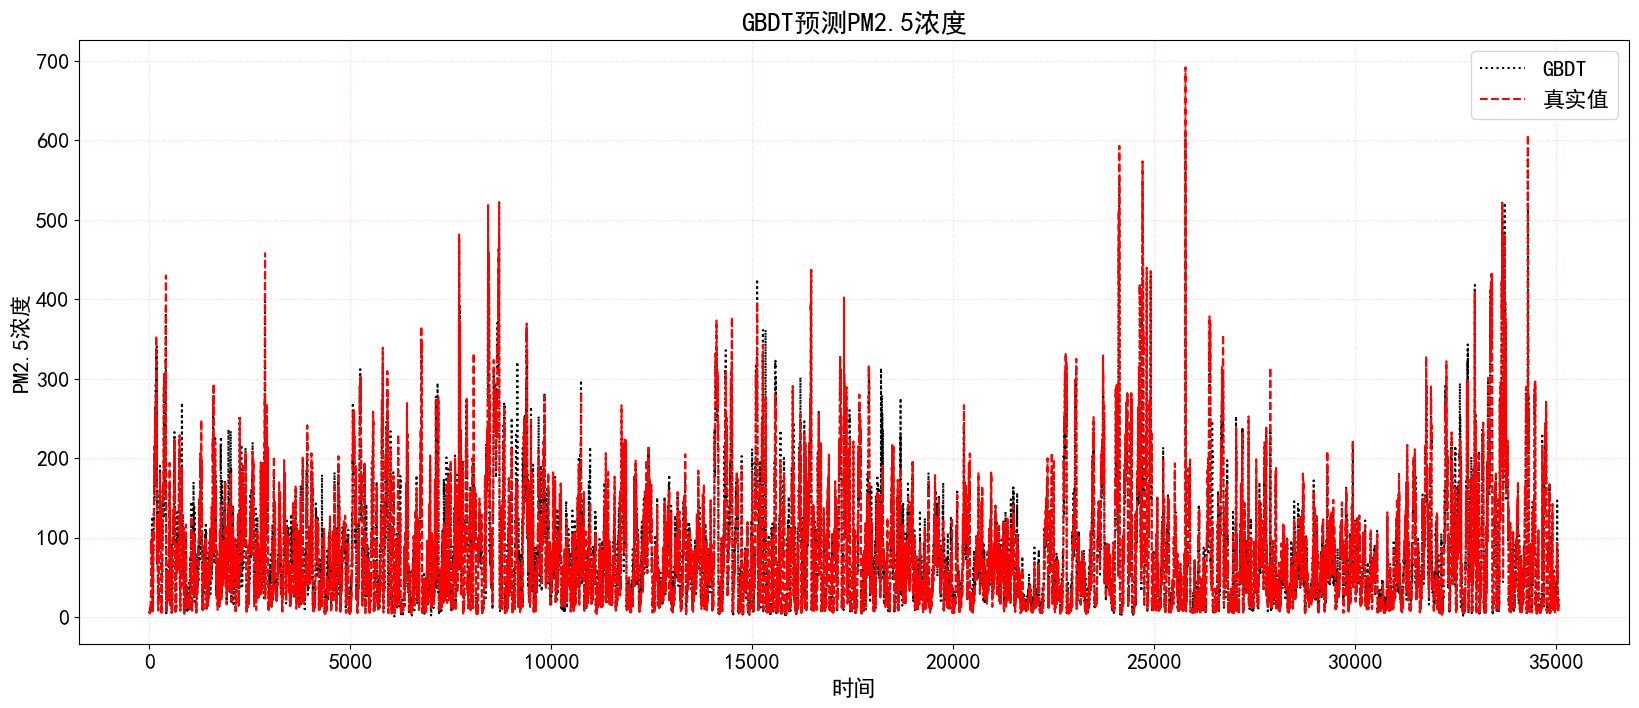

'C:\\Users\\lucien7676\\machine_learning_homework\\GBDT.html'

In [25]:
dic2,c2 = lrc.main2(want="GBDT")
c2.render("./GBDT.html")

CART模型的MSE为0.03317037797114456
CART模型的R2为0.9668296220288555


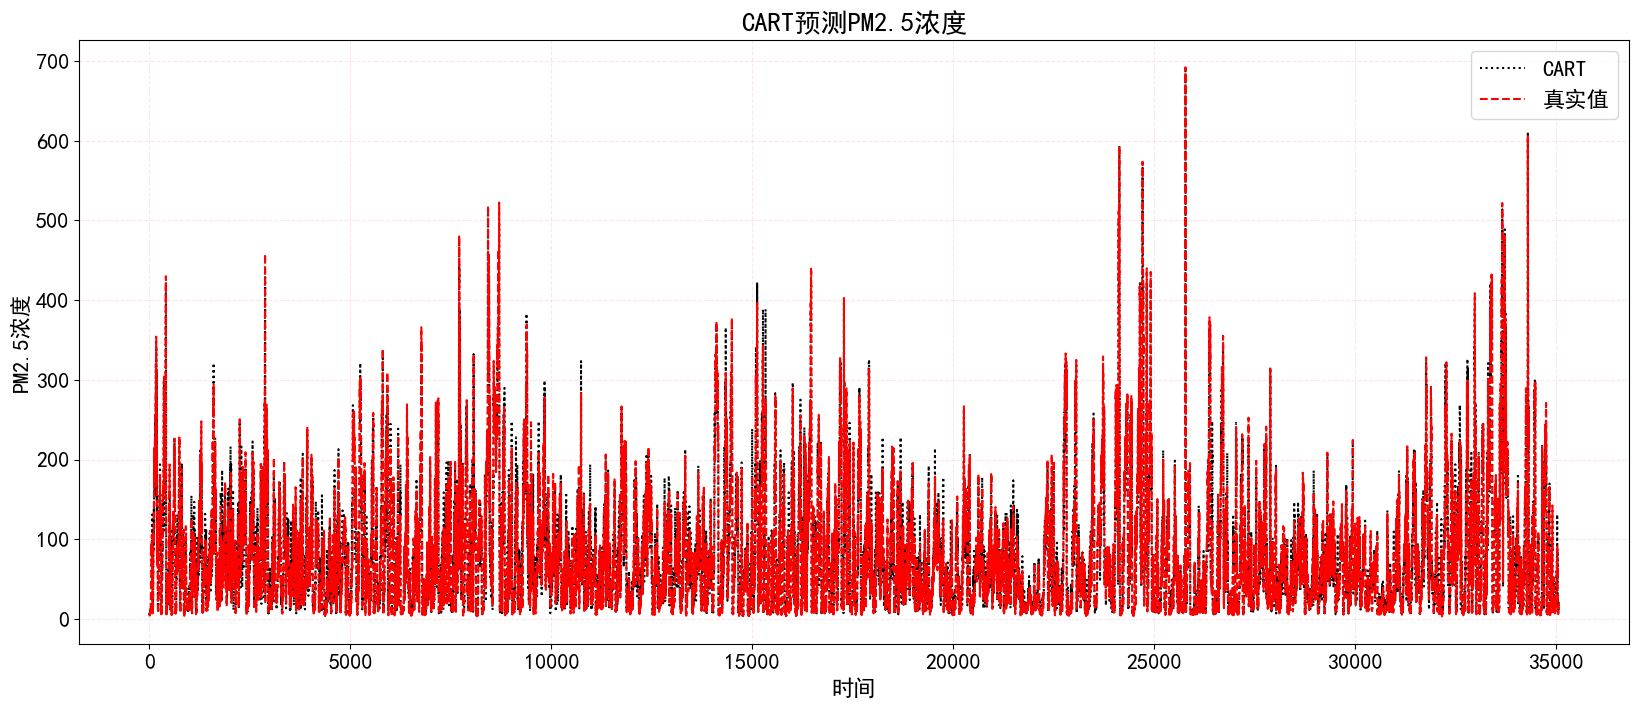

'C:\\Users\\lucien7676\\machine_learning_homework\\CART.html'

In [26]:
dic3,c3 = lrc.main2(want="CART")
c3.render("./CART.html")

AdaBoost模型的MSE为0.135661324579858
AdaBoost模型的R2为0.864338675420142


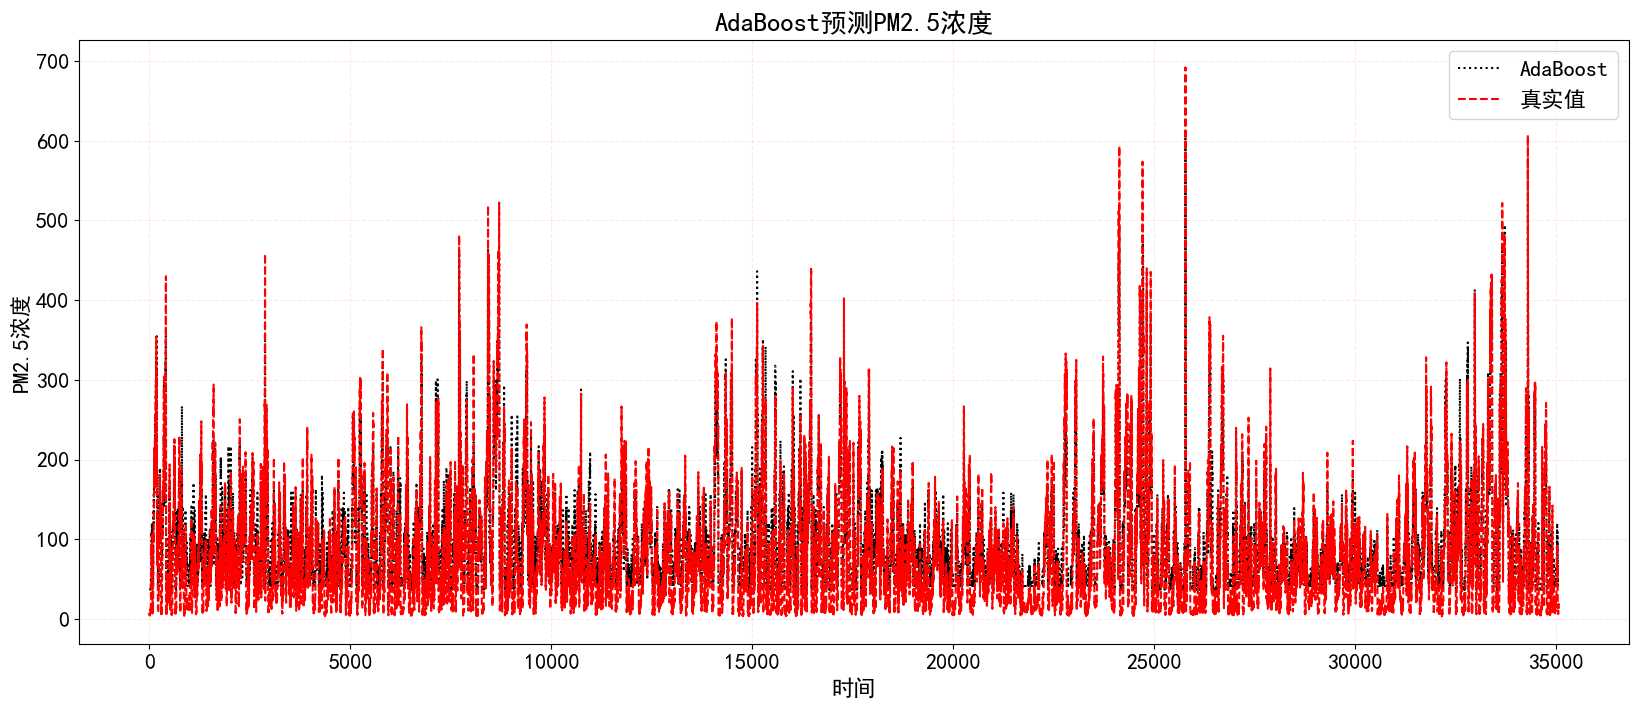

'C:\\Users\\lucien7676\\machine_learning_homework\\AdaBoost.html'

In [28]:
dic4,c4 = lrc.main2(want="AdaBoost")
c4.render("./AdaBoost.html")

[17:13:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost模型的MSE为0.009638336568365857
XGBoost模型的R2为0.9903616634316341


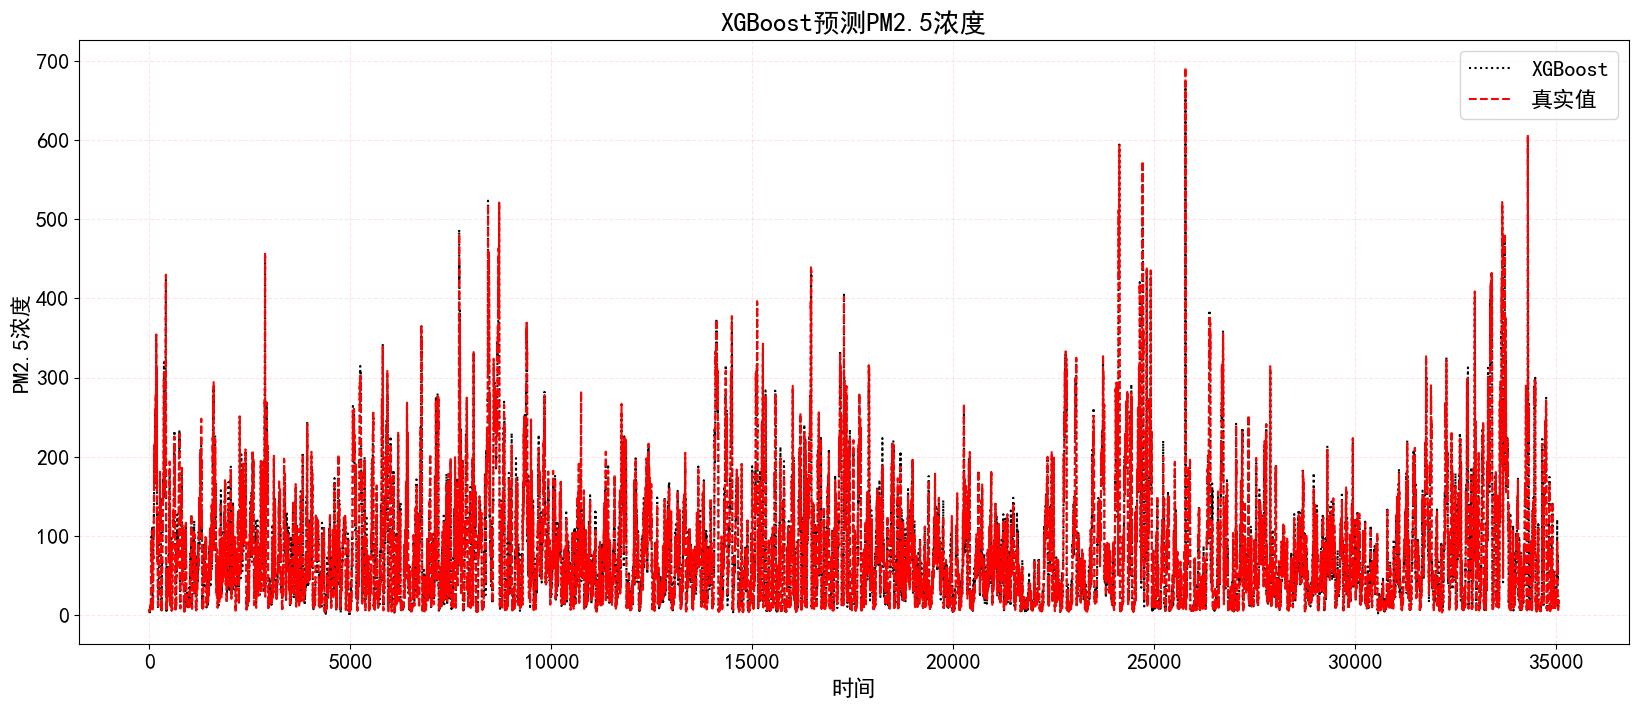

'C:\\Users\\lucien7676\\machine_learning_homework\\XGBoost.html'

In [29]:
dic5,c5 = lrc.main2(want="XGBoost")
c5.render("./XGBoost.html")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RF模型的MSE为0.0037771947302411733
RF模型的R2为0.9962228052697588


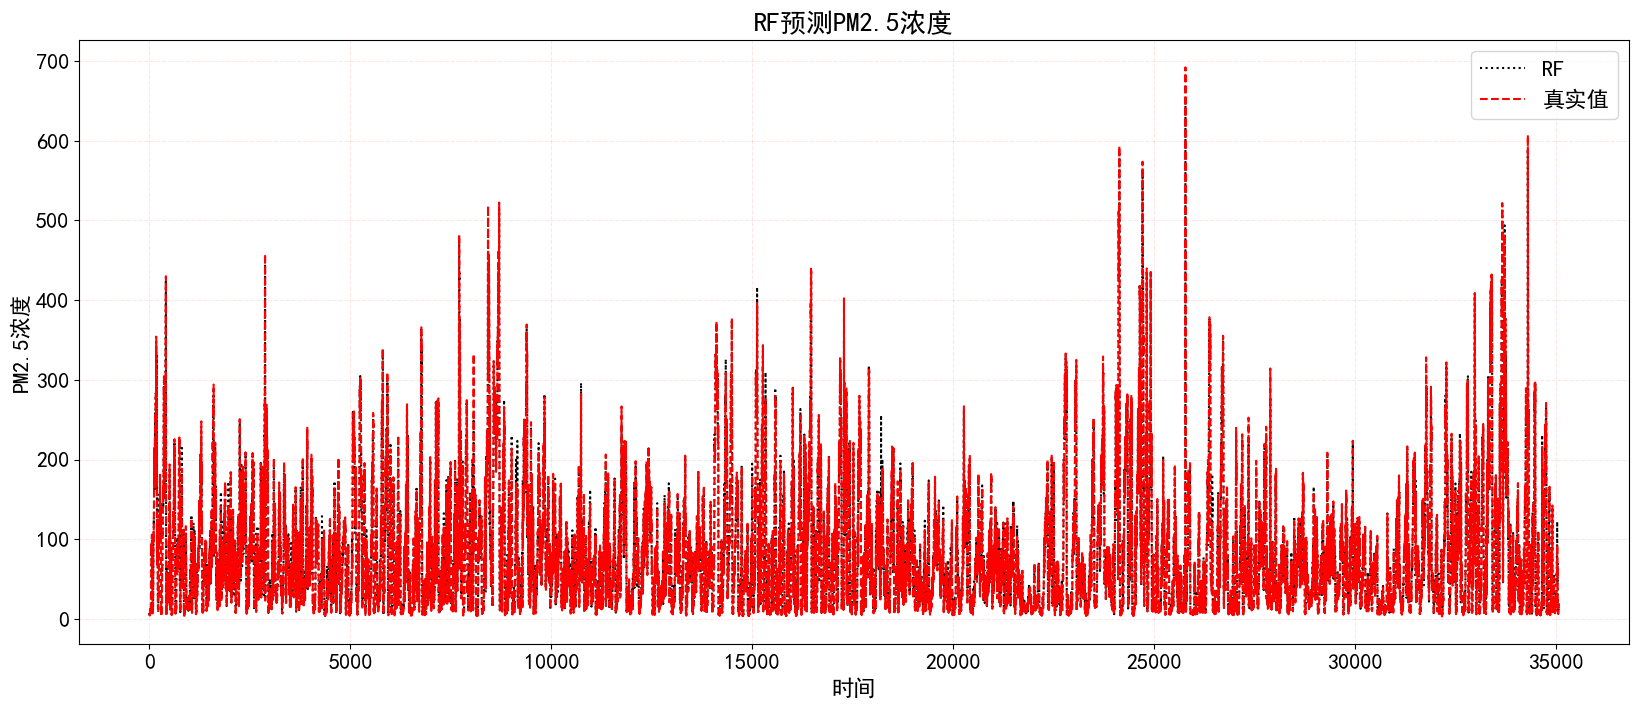

'C:\\Users\\lucien7676\\machine_learning_homework\\RF.html'

In [31]:
dic6,c6 = lrc.main2(want="RF")
c6.render("./RF.html")

In [ ]:
# 进行PCA降维比较
# 这里我们主要对BP神经网络和XGBoost进行PCA降维处理

## 这里本来想要进行PCA进行降维，但后面尝试了一下发现其实没有降维的必要，下面是尝试的过程

In [59]:
# 首先我们先创建一个PCA对象
pca=PCA(n_components=15) # 这里我们先不做降维的操作，我们首先先看一下投影后的方差的比例然后后面才能决定到底要降到几个维度
# 首先我们先提取出一个数据框进行查看要降到几个维度
X=data_param['Aotizhongxin']['X']
#print(X)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
# 然后这里发现其实没有必要降维，她每一个特征贡献率还是比较明显的


[0.24614955 0.17476333 0.10156335 0.07505894 0.06698641 0.0668591
 0.06577983 0.05754906 0.04855394 0.03111629 0.02196757 0.01572204
 0.01279858 0.01016833 0.00496368]
[3.69235923 2.6215323  1.52349818 1.12591942 1.0048277  1.00291806
 0.98672847 0.86326306 0.72833204 0.46675896 0.32952393 0.23583801
 0.19198474 0.15252978 0.07445761]
